In [1]:
import pandas as pd
import numpy as np 
from bed_reader import open_bed, sample_file
import time

In [2]:
pip install bed_reader

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
phen = pd.read_csv("height&id.csv")
phen = phen.iloc[:,[1,2]]
phenidnonmiss = phen.drop(np.where(np.array(np.transpose(phen.iloc[:,1])).astype('str') == 'nan')[0])
from bed_reader import open_bed
with open_bed("chr20.bed") as bed3:
    idd = bed3.iid[:];
    print(idd.shape)
    
common_iid = np.intersect1d(idd,phenidnonmiss['eid'])
common_iid = common_iid.astype('int64')
order_common_iid = idd[np.where(np.isin(idd,common_iid)==True)[0]]
argsort = np.argsort(order_common_iid.astype('int64'))
phen_filt = phenidnonmiss.loc[phenidnonmiss['eid'].isin(common_iid)];
height_unordered = phen_filt['50-0.0'] 
height = np.array(height_unordered)#[argsort]
comn_snps = pd.read_csv("index_common.csv")

with open_bed("chr20.bed") as bed3:
    snp = bed3.sid[(5*np.arange(3800))]
    X = bed3.read(index=np.s_[np.where(np.isin(idd,common_iid)==True)[0][argsort],(5*np.arange(3800))])
    print(X)
    print(X.shape)
    
y=height   #### Vector of height
X = pd.DataFrame(X);   ###### Design Matrix of Genotypes
prop_nan = np.divide((X.isna().sum()),X.shape[0])
idx3 = np.where(prop_nan<0.1)[0]
X = X.loc[:, idx3]
snp_id = snp[idx3]
X = X.fillna(X.mean());
idx1 = np.where(X.isna().any() == False)[0];
X = X.iloc[:,idx1];
snp_id = snp_id[idx1];
idx2 = (X != 0).any(axis=0);
X = X.loc[:, idx2]
snp_id = snp_id[idx2]
print(X)
print(snp_id)
X = (X - np.mean(X)) #/ np.std(X)
y = (y-np.mean(y))#/np.std(y)
XTXinv = np.linalg.inv(np.matmul(np.transpose(np.array(X)),np.array(X)));
XTy = np.matmul(np.transpose(np.array(X)),np.array(y));
betahat = np.matmul(XTXinv,XTy)
e =  y-np.matmul(np.array(X),betahat)
est_sigma = np.sqrt(np.dot(e,e)/(np.shape(X)[0]-np.shape(X)[1]))
S_inv = np.diag(np.sqrt(1./np.diag(np.array(XTXinv))));
corrzscore = (np.matmul(np.matmul(S_inv,XTXinv),S_inv));  ### Correlationn among the z-scores
del XTXinv
del e
del XTy
zscore = np.matmul(S_inv,betahat)/est_sigma   ###### z-scores of the SNPs

(488377,)
[[0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(486725, 3800)
        0     1         2     3     4     5     6     7     8     10    ...  \
0        0.0   1.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1        0.0   0.0  0.000000   0.0   0.0   2.0   1.0   1.0   0.0   1.0  ...   
2        0.0   1.0  0.000000   1.0   1.0   1.0   1.0   0.0   0.0   0.0  ...   
3        0.0   1.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4        0.0   1.0  0.366273   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
...      ...   ...       ...   ...   ...   ...   ...   ...   ...   ...  ...   
486720   0.0   0.0  0.000000   0.0   2.0   0.0   0.0   0.0   0.0   0.0  ...   
486721   0.0   1.0  0.000000   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
486722   0.0   0.0  0.000000   0.0   0.0   2.0   2.0   0.0   0.0   0.0  ...   
486723   0.0   1.0  0.000000 

In [4]:
pd.DataFrame(corrzscore).to_csv("corr3.5kjump.csv")  ### Coorelation matrix among the z-scores in our uk biobank data

In [5]:
pd.DataFrame(zscore).to_csv("z_scores2035K.csv")

In [6]:
cov=corrzscore
del corrzscore

In [7]:
import numpy as np
import math 
import itertools as itertools
from itertools import product
def locFDRS_GWAS_thread(Z,cov,B,b,pi,tau):
  K = np.size(Z);
  locFDR = np.zeros(K);
  for i in range(K):
    Z_sub = Z[max(i-B,0):(min(i+B,K-1)+1)];
    cov_sub = cov[max(i-B,0):(min(i+B,K-1)+1),max(i-B,0):(min(i+B,K-1)+1)];
    l = min(i+B,K-1) - max(i-B,0) + 1;
    H = product([0,1], repeat=l);                                           
    sum1 = sum2 = 0;
    for s in H:
      if(s[min(B,i)] == 0): 
        #t = (multivariate_normal.pdf(Z_sub,mean=np.multiply(s,b),cov = cov_sub+np.multiply(np.diag(s),pow(tau,2)))*pow(pi,sum(s)) * pow(1-pi,l-sum(s)))
        t = ((np.exp(-(1/2)*np.dot(np.inner((Z_sub - np.multiply(s,b)), 
                                         np.linalg.inv(cov_sub+np.multiply(np.diag(s),pow(tau,2)))),
                                  (Z_sub - np.multiply(s,b))))* 
          pow(pi,sum(s)) * pow(1-pi,l-sum(s)))/np.sqrt(np.linalg.det(cov_sub+np.multiply(np.diag(s),pow(tau,2)))));
        sum1 = sum1 + t;
        sum2 = sum2 + t;
      else:
        #sum2 = sum2 + (multivariate_normal.pdf(Z_sub,mean=np.multiply(s,b),cov = cov_sub+np.multiply(np.diag(s),pow(tau,2)))*pow(pi,sum(s)) * pow(1-pi,l-sum(s)))
        sum2 = sum2 + ((np.exp(-(1/2)*np.inner(np.dot(Z_sub - np.multiply(s,b), 
                                         np.linalg.inv(cov_sub+np.multiply(np.diag(s),pow(tau,2)))),
                                  (Z_sub - np.multiply(s,b))))* 
          pow(pi,sum(s)) * pow(1-pi,l-sum(s)))/np.sqrt(np.linalg.det(cov_sub+np.multiply(np.diag(s),pow(tau,2)))));
    locFDR[i]= sum1/sum2;
  
  
  return(locFDR);



def rejected_cutoff(lcfdr,cutoff):
    return(np.where(lcfdr<cutoff));

In [9]:
import math 
import itertools as itertools
from itertools import product
maxiter = 5000;
pi_est = 0.2   ##### pi estimated by Sun and Cai method given in the R script "sun_cai(2007)_est.R"
blocks = 3;
[b_est,tausq_est]=[0,0];

for i in range(blocks):
    est_mat = np.zeros(2*maxiter).reshape(maxiter ,2)
    z = zscore[((blocks*(np.arange(1193))-i))];
    cov_sub = np.array(pd.DataFrame(cov).iloc[((blocks*(np.arange(1193))-i)),((blocks*(np.arange(1193))-i))])
    b_ini = np.mean(z)/pi_est; tausq_ini = np.amax([0.,(np.var(z)-1-(pow(b_ini,2)*(1-pow(pi_est,2))))/pi_est]); 
    est_mat[0,0] = b_ini; est_mat[0,1] = tausq_ini;
    for iter in 1+np.arange(maxiter-1):
      p_tau = 1-locFDRS_GWAS_thread(z,cov_sub,0,b_ini,pi_est,np.sqrt(tausq_ini));
      #pi_next = np.mean(p_tau);
      b_next = (np.sum((p_tau)*z)/np.sum((p_tau)));
      tausq_next = np.amax([0,(np.sum((p_tau)*pow(z-b_next,2))
      /np.sum((p_tau)))-1]);
      b_ini = b_next; tausq_ini = tausq_next;
      est_mat[iter,0] = b_ini; est_mat[iter,1] = tausq_ini;
      if np.amax(abs(est_mat[iter,:]-est_mat[iter-1,:])) < pow(10,-10):
        break;
    [b_est,tausq_est]=[b_est,tausq_est]+est_mat[iter,:];
    print(est_mat[iter,:]);

[b_est,tausq_est] =  np.divide([b_est,tausq_est],blocks);
[pi_est,b_est,tausq_est]  #### Estimate of the model parameters in our uk biobank data

[0.0236678  2.14118236]
[0.18326777 2.68535609]
[0.06869159 2.60498021]


[0.2, 0.09187572243452065, 2.477172885461154]

In [10]:
[pi_est,b_est,tausq_est] = [0.2, 0.09187484411282405, 2.4771687763827965];
[pi_est,b_est,tausq_est]

[0.2, 0.09187484411282405, 2.4771687763827965]

In [11]:
lcfdr0 = locFDRS_GWAS_thread(zscore,cov,0,b_est,pi_est,np.sqrt(tausq_est))
lcfdr1 = locFDRS_GWAS_thread(zscore,cov,1,b_est,pi_est,np.sqrt(tausq_est))
lcfdr2 = locFDRS_GWAS_thread(zscore,cov,2,b_est,pi_est,np.sqrt(tausq_est))
lcfdr3 = locFDRS_GWAS_thread(zscore,cov,3,b_est,pi_est,np.sqrt(tausq_est))
lcfdr4 = locFDRS_GWAS_thread(zscore,cov,4,b_est,pi_est,np.sqrt(tausq_est))
lcfdr5 = locFDRS_GWAS_thread(zscore,cov,5,b_est,pi_est,np.sqrt(tausq_est))

In [12]:
import statsmodels.stats.multitest
from scipy.stats import norm
pd.DataFrame([lcfdr0,lcfdr1,lcfdr2,lcfdr3,lcfdr4,lcfdr5,2*(1-norm.cdf(abs(zscore)))]).to_csv("lcfdrsch2035K.csv")

In [15]:
import pandas as pd
import numpy as np
lcfdrs = pd.read_csv("lcfdrsch2035K.csv");
lcfdr0 = np.array(lcfdrs.head(8))[0][1:3581]
lcfdr1 = np.array(lcfdrs.head(8))[1][1:3581]
lcfdr2 = np.array(lcfdrs.head(8))[2][1:3581]
lcfdr3 = np.array(lcfdrs.head(8))[3][1:3581]

In [16]:
alpha = 0.05;
pi_est = 0.2; #### Estimated by Sun and Cai method for which use the R codes


rejidx = pd.read_csv("S&Creject0.05&35.csv")
np.array(rejidx['x'])

print('Rejections by S&C')
print(np.size(np.array(rejidx['x'])))

print('Intersection of Rejections by S&C and locFDR_N')
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))

print('Intersection of Rejections by ABH and locFDR_N')

print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))

print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))

print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))

print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))



print('Rejections by ABH')
print(np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha/(1-pi_est)), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]))

print('Rejections by BH')
print(np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]))


print('Rejections by locFDR_N')
print(np.size(rejected_cutoff(lcfdr0,0.13891)))
print(np.size(rejected_cutoff(lcfdr1,0.14356)))
print(np.size(rejected_cutoff(lcfdr2,0.14667)))
print(np.size(rejected_cutoff(lcfdr3,0.14683)))

print('Intersection of Rejections by BH and ABH')
print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]])))

print('Intersection of Rejections by S&C and ABH')
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha)/(1-pi_est), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]])))

print('Intersection of Rejections by S&C and BH')
print(np.size(np.intersect1d(snp[np.array(rejidx['x'])],
                     snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]])))



print('Intersection of Rejections by BH and locFDR_N')
print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zscore))), 
                                                   alpha=(alpha), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))



print('Intersection of Rejections by T_0 and locFDR_N')
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr0,0.13891)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr0,0.13891)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr0,0.13891)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr0,0.13891)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))


print('Intersection of Rejections by T_1 and locFDR_N')
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr1,0.14356)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr1,0.14356)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr1,0.14356)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr1,0.14356)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))


print('Intersection of Rejections by T_2 and locFDR_N')
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr2,0.14667)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr2,0.14667)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr2,0.14667)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr2,0.14667)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))


print('Intersection of Rejections by T_3 and locFDR_N')
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr3,0.14683)[0]],
                     snp[rejected_cutoff(lcfdr0,0.13891)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr3,0.14683)[0]],
                     snp[rejected_cutoff(lcfdr1,0.14356)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr3,0.14683)[0]],
                     snp[rejected_cutoff(lcfdr2,0.14667)[0]])))
print(np.size(np.intersect1d(snp[rejected_cutoff(lcfdr3,0.14683)[0]],
                     snp[rejected_cutoff(lcfdr3,0.14683)[0]])))

Rejections by S&C
36
Intersection of Rejections by S&C and locFDR_N
36
33
35
32
Intersection of Rejections by ABH and locFDR_N
36
33
35
33
Rejections by ABH
36
Rejections by BH
20
Rejections by locFDR_N
49
53
66
64
Intersection of Rejections by BH and ABH
20
Intersection of Rejections by S&C and ABH
34
Intersection of Rejections by S&C and BH
20
Intersection of Rejections by BH and locFDR_N
20
19
20
20
Intersection of Rejections by T_0 and locFDR_N
49
43
45
40
Intersection of Rejections by T_1 and locFDR_N
43
53
52
49
Intersection of Rejections by T_2 and locFDR_N
45
52
66
60
Intersection of Rejections by T_3 and locFDR_N
40
49
60
64


/var/folders/n8/zvsqhbgs12q6f34fw9nnh72c0000gn/T/ipykernel_89189/2903616235.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.stem(1+np.arange(3580),-2*np.log10(2*(1-norm.cdf(abs(zscore)))), markerfmt=' ')


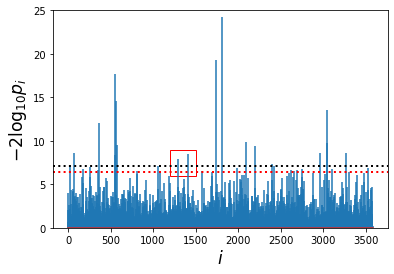

In [19]:
############ Manhattan Plots for BH & ABH procedure #############
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


fig, ax = plt.subplots()

ax.set_ylabel('$-2\log_{10}{p_{i}}$',fontsize="xx-large")  # Add an x-label to the axes.
ax.set_xlabel('$i$',fontsize="xx-large")  # Add a y-label to the axes.
ax.stem(1+np.arange(3580),-2*np.log10(2*(1-norm.cdf(abs(zscore)))), markerfmt=' ')
plt.ylim(0,25)
plt.axhline(y=-2*np.log10((20*0.05)/(3580*1)),
            linewidth= 2, color='k', linestyle= 'dotted')
plt.axhline(y=-2*np.log10((36*0.05)/(3580*0.8)),
            linewidth= 2, color='r', linestyle= 'dotted')
rect = patches.Rectangle((1200, 6), 300, 3, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()
fig.savefig(fname = 'manhatton_zscore_BH_ABH_adj.png')

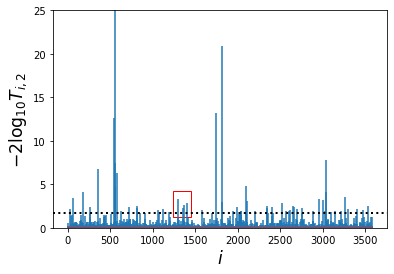

In [20]:
############## Manhattan Plots T_N procedure ################

import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

ax.set_ylabel('$-2\log_{10}{T_{i,2}}$',fontsize="xx-large")  # Add an x-label to the axes.
ax.set_xlabel('$i$',fontsize="xx-large")  # Add a y-label to the axes.
ax.stem(1+np.arange(3580),-2*np.log10(lcfdr2), markerfmt=' ')
plt.ylim(0,25)

'''\hat t_0 = 0.13891;
\hat t_1 = 0.14356;
\hat t_2 = 0.14667;
\hat t_3 = 0.14683;'''

rect = patches.Rectangle((1240, 1.2), 210, 3, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axhline(y=-2*np.log10(0.14667),
            linewidth= 2, color='k', linestyle= 'dotted')
plt.show()
fig.savefig(fname = 'manhatton_lcfdr2_cutoff.png')